#Topic ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÑ‡∏ó‡∏¢‡πÄ‡∏£‡∏≤‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£ ‡∏ú‡∏•‡∏¥‡∏ï‡∏Å‡∏£‡∏∞‡πÅ‡∏™‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô‡∏à‡∏£‡∏¥‡∏á ‡πÜ ‡∏°‡∏±‡πâ‡∏¢# New Section

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates

In [ ]:
url = "https://docs.google.com/spreadsheets/d/1oMD7GTQ1RslgVAESNMMLA2J6njxn1OwG/export?format=xlsx"

In [ ]:
data = pd.read_excel(url, sheet_name="Master table")
df_peak = pd.read_excel(url, sheet_name="Elec_Peak_Gen")

In [ ]:
data['ID'] = pd.to_datetime(
    data['Year'].astype(str) + '-' + data['Date'],
    format='%Y-%b'
    )
# ‡πÄ‡∏ß‡∏•‡∏≤‡πÇ‡∏ä‡∏ß‡πå format 2025-Jan ‡πÅ‡∏ï‡πà‡∏¢‡∏±‡∏á‡πÄ‡∏õ‡πá‡∏ô datetime ‡∏≠‡∏¢‡∏π‡πà
data['Year-Month'] = data['ID'].dt.strftime('%Y-%b')
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Date'], format='%Y-%b').dt.strftime('%b').str.upper()
data["Year"] = data["Year"].astype(int)
data = data.rename(columns={"Date":"Month"}).sort_values(by="ID")
month_order = ["JAN","FEB","MAR","APR","MAY","JUN",
               "JUL","AUG","SEP","OCT","NOV","DEC"]
data['Month'] = pd.Categorical(
    data['Month'],
    categories=month_order,
    ordered=True
)


data["Quarter"] = data["ID"].dt.quarter
data["Quarter"] = "Q" + data["Quarter"].astype(str)
col = ['Year-Month','Year','Quarter','Month'] + [c for c in data.columns if c != 'Year-Month' and c != 'Year' and c !='Quarter' and c != 'Month']
data = data[col]
data = data.set_index('ID').sort_index()
data.to_csv("data.csv")

In [ ]:
df = data.copy()
df["Year-Month"] = pd.to_datetime(df["Year-Month"])
df = df.sort_values("Year-Month")

month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
             'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
if "Year-Month" not in df.columns:
    df["Month_Num"] = df["Date"].astype(str).str.upper().map(month_map)
    df["Year-Month"] = pd.to_datetime(
        df["Year"].astype(int).astype(str) + "-" +
        df["Month_Num"].astype(int).astype(str) + "-01",
        format="%Y-%m-%d", errors="coerce"
    )
# Convert Year-Month to datetime if not already
#df_norm = df_norm.copy()
df.index = pd.to_datetime(df.index, errors="coerce")


/tmp/ipython-input-3157686263.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Year-Month"] = pd.to_datetime(df["Year-Month"])


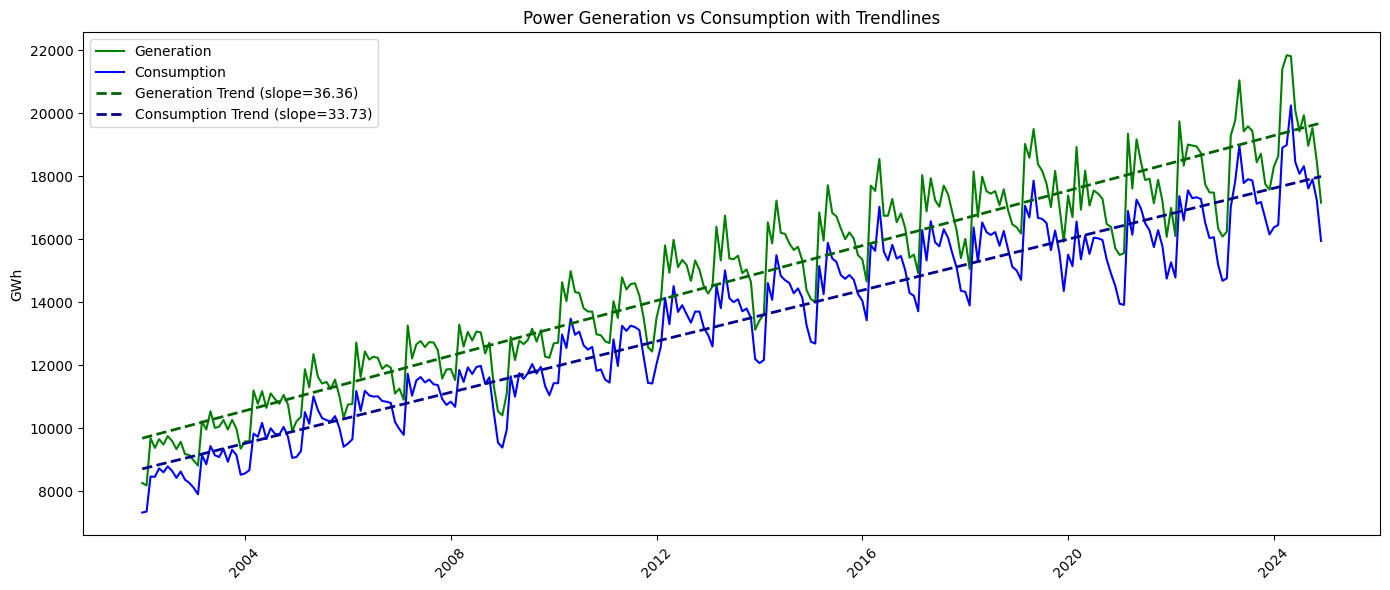

In [ ]:
x = np.arange(len(df))  # ‡πÉ‡∏ä‡πâ index ‡πÄ‡∏õ‡πá‡∏ô‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö regression

# Fit linear regression
coeffs_gen = np.polyfit(x, df["POWER GENERATION (GWh)"], 1)
coeffs_cons = np.polyfit(x, df["Electrical consump Grand Total (GWh)"], 1)

trend_gen = np.poly1d(coeffs_gen)
trend_cons = np.poly1d(coeffs_cons)

plt.figure(figsize=(14,6))

# Plot actual data
plt.plot(df["Year-Month"], df["POWER GENERATION (GWh)"], label="Generation", color="green")
plt.plot(df["Year-Month"], df["Electrical consump Grand Total (GWh)"], label="Consumption", color="blue")

# Plot trend lines
plt.plot(df["Year-Month"], trend_gen(x), "--", color="darkgreen", linewidth=2, label=f"Generation Trend (slope={coeffs_gen[0]:.2f})")
plt.plot(df["Year-Month"], trend_cons(x), "--", color="darkblue", linewidth=2, label=f"Consumption Trend (slope={coeffs_cons[0]:.2f})")

plt.title("Power Generation vs Consumption with Trendlines")
plt.ylabel("GWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


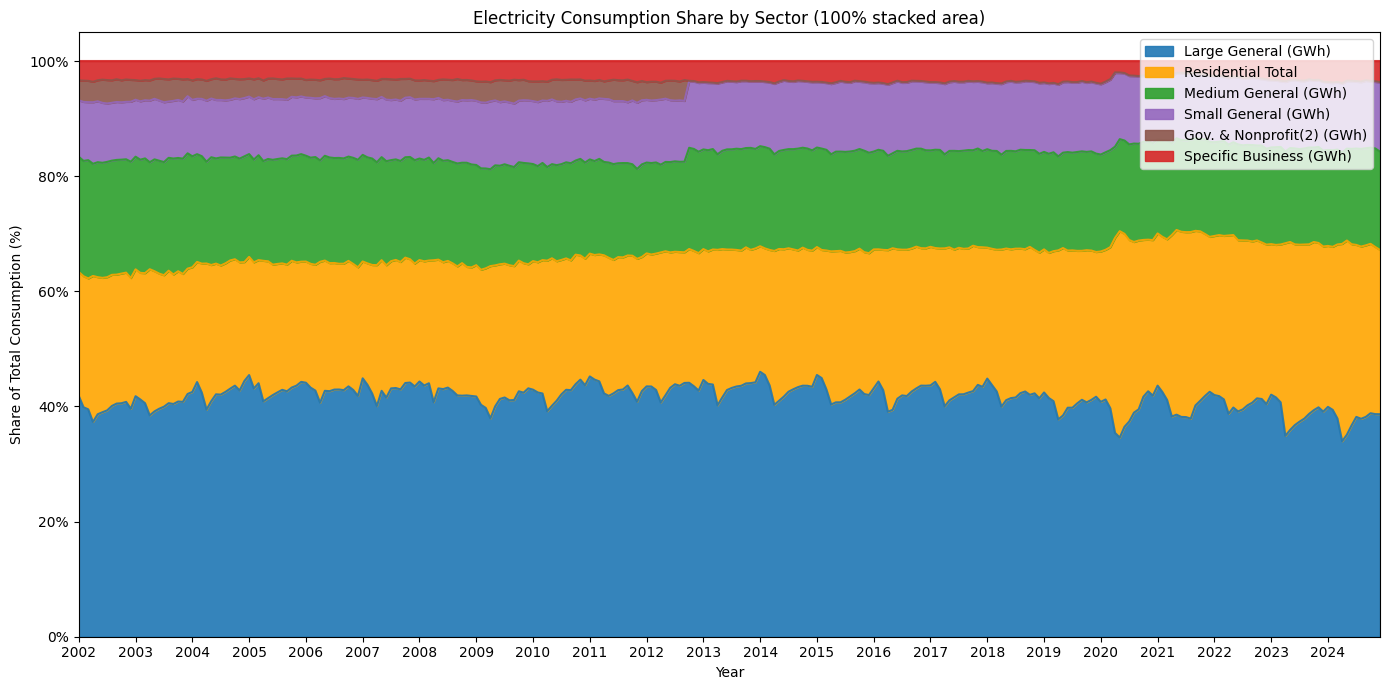

In [ ]:
# --- Select key sectors ---
cols = [
    "Large General (GWh)",
    "Residential Total",
    "Medium General (GWh)",
    "Small General (GWh)",
    "Gov. & Nonprofit(2) (GWh)",
    "Specific Business (GWh)"
]

# --- Prep dataframe ---
df_plot = df[["Year-Month"] + cols].copy()
# (optional but robust) ensure numeric
for c in cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")
df_plot = df_plot.set_index("Year-Month")

# --- Normalize to % (stacked to 100%) ---
df_norm = df_plot.div(df_plot.sum(axis=1), axis=0) * 100

# --- Colors (define BEFORE plotting) ---
custom_colors = {
    "Large General (GWh)": "#1f77b4",      # blue
    "Residential Total": "orange",         # orange
    "Medium General (GWh)": "#2ca02c",     # green
    "Small General (GWh)": "#9467bd",      # purple
    "Gov. & Nonprofit(2) (GWh)": "#8c564b",# brown
    "Specific Business (GWh)": "#d62728"   # red
}
color_list = [custom_colors[c] for c in df_norm.columns]


fig, ax = plt.subplots(figsize=(14,7))
df_norm.plot.area(
    stacked=True,
    color=[custom_colors[c] for c in df_norm.columns],
    alpha=0.9,
    ax=ax
)

ax.set_title("Electricity Consumption Share by Sector (100% stacked area)")
ax.set_ylabel("Share of Total Consumption (%)")
ax.set_xlabel("Year")

# Format y-axis as percentage with no decimals
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

# --- Force yearly ticks using the original df_norm.index ---
years = pd.period_range(df_norm.index.min(), df_norm.index.max(), freq="Y").to_timestamp()
ax.set_xticks(years)
ax.set_xticklabels([d.strftime("%Y") for d in years])
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.legend(loc="upper right")
ax.grid(False)
plt.tight_layout()
plt.show()

## **Hypothesis 1 ‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥, ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏°‡∏±‡πà‡∏á‡∏Ñ‡∏±‡πà‡∏á‡∏ó‡∏≤‡∏á‡πÄ‡∏®‡∏£‡∏©‡∏ê‡∏Å‡∏¥‡∏à, ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏õ‡∏£‡∏∞‡∏ä‡∏≤‡∏Å‡∏£, ‡∏û‡∏§‡∏ï‡∏¥‡∏Å‡∏£‡∏£‡∏°‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ‡πÄ‡∏õ‡πá‡∏ô‡∏õ‡∏±‡∏à‡∏à‡∏±‡∏¢‡∏ó‡∏µ‡πà‡∏™‡πà‡∏á‡∏ú‡∏•‡∏ï‡πà‡∏≠‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà**




### **1.1 ‡∏≠‡∏∏‡∏ì‡∏´‡∏†‡∏π‡∏°‡∏¥‡∏™‡πà‡∏á‡∏ú‡∏•‡∏ï‡πà‡∏≠‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà**

/tmp/ipython-input-3197561139.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Year","Month"], as_index=False)["LF_frac"].mean()


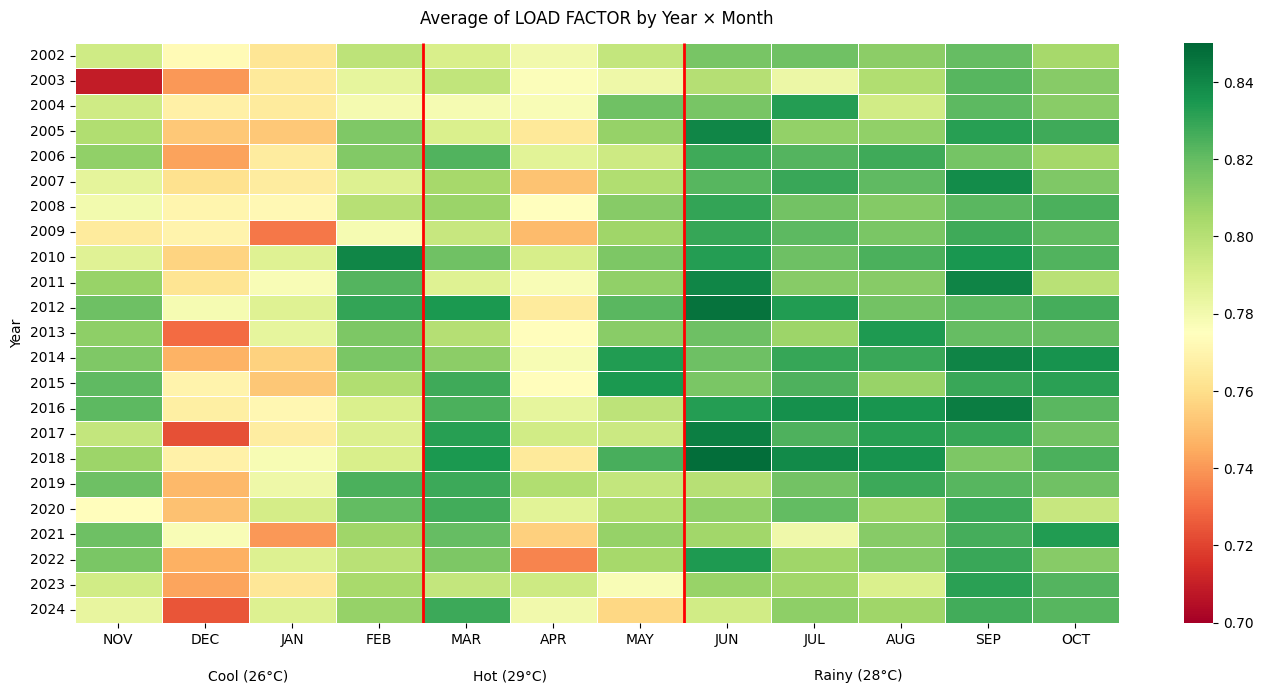

In [ ]:
# --- Prep as you already have ---
df["LOAD FACTOR (%)"] = pd.to_numeric(df["LOAD FACTOR (%)"], errors="coerce")
df["LF_frac"] = df["LOAD FACTOR (%)"] / (100 if df["LOAD FACTOR (%)"].mean() > 1 else 1)

month_order = ["NOV","DEC","JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT"]
df["Month"] = pd.Categorical(df["Month"].astype(str).str.upper(),
                             categories=month_order, ordered=True)

piv = (
    df.dropna(subset=["Year","Month","LF_frac"])
      .groupby(["Year","Month"], as_index=False)["LF_frac"].mean()
      .pivot(index="Year", columns="Month", values="LF_frac")
      .sort_index()
)

# --- Plot heatmap ---
plt.figure(figsize=(14, 7))
ax = sns.heatmap(
    piv,
    cmap="RdYlGn",
    vmin=0.70, vmax=0.85,
    annot=False,
    linewidths=0.4, linecolor="white",
    cbar=True
)

ax.set_title("Average of LOAD FACTOR by Year √ó Month", pad=14)
ax.set_xlabel("")
ax.set_ylabel("Year")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# ---------- Add seasonal separators & labels ----------
# Month index positions (cell boundaries) for separators:
# NOV(0) DEC(1) JAN(2) FEB(3) | MAR(4) APR(5) MAY(6) | JUN(7) JUL(8) AUG(9) SEP(10) OCT(11)
sep_positions = [4, 7]  # before MAR and before JUN

# draw vertical red lines
ymin, ymax = ax.get_ylim()  # note: heatmap inverts y-axis, but vlines respects these values
for x in sep_positions:
    ax.vlines(x, ymin, ymax, colors="red", linewidth=2)

# draw a red border rectangle
# from matplotlib.patches import Rectangle
# ax.add_patch(Rectangle((0, 0), 12, piv.shape[0],
#                        fill=False, edgecolor="red", linewidth=2))

# group labels at the bottom
# use axis transform so text sits just below the x-axis regardless of data limits
trans = ax.get_xaxis_transform()
ax.text(2.0, -0.08, "Cool (26¬∞C)", ha="center", va="top", transform=trans, color="black")
ax.text(5.0, -0.08, "Hot (29¬∞C)",  ha="center", va="top", transform=trans, color="black")
ax.text(9.0, -0.08, "Rainy (28¬∞C)",ha="center", va="top", transform=trans, color="black")

# # optional: thin red baseline under labels to match the look
# ax.hlines(y=-0.005*(ymax - ymin), xmin=0, xmax=12, colors="red", linewidth=2, transform=ax.transData)

plt.tight_layout()
plt.show()


### **1.2 ‡∏õ‡∏£‡∏¥‡∏°‡∏≤‡∏ì‡∏Å‡∏≤‡∏£‡∏ú‡∏•‡∏¥‡∏ï‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≠‡∏î‡∏Ñ‡∏•‡πâ‡∏≠‡∏á‡∏Å‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡πÄ‡∏à‡∏£‡∏¥‡∏ç‡πÄ‡∏ï‡∏¥‡∏ö‡πÇ‡∏ï‡∏Ç‡∏≠‡∏á‡πÄ‡∏®‡∏£‡∏©‡∏ê‡∏Å‡∏¥‡∏à‡πÉ‡∏ô‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà**

/tmp/ipython-input-4134159572.py:11: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  gen_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["GEN_m_yoy%"].mean()
/tmp/ipython-input-4134159572.py:12: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  con_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["CON_m_yoy%"].mean()
/tmp/ipython-input-4134159572.py:15: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  gdp_q_sum = df.resample("Q-DEC", on="Year-Month")["GDP (Milion of Baht)"].sum(min_count=1)


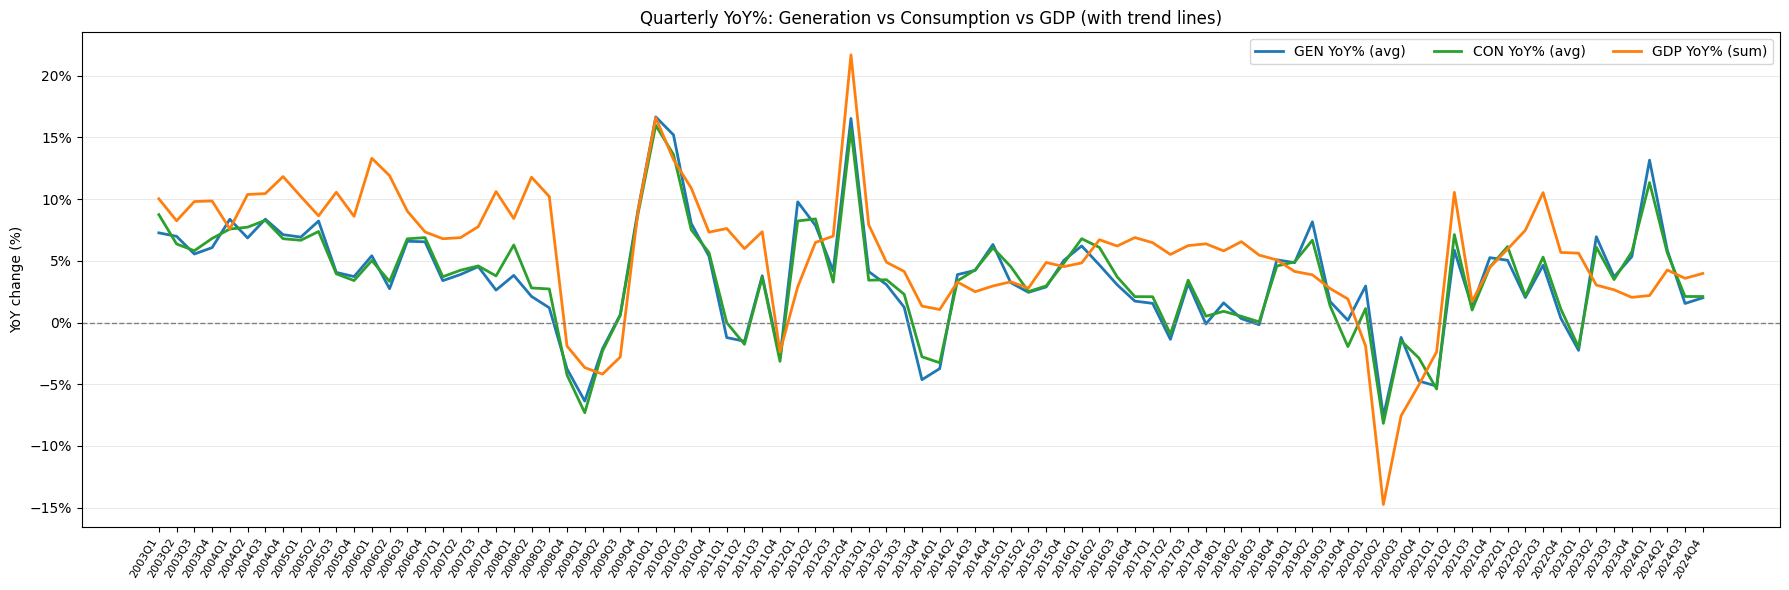

In [ ]:
# ---------------------------
# Step 2: Quarterly YoY% table
# ---------------------------

# 1) Compute MONTHLY YoY% (lag 12 months)
df["GEN_m_yoy%"] = df["POWER GENERATION (GWh)"].pct_change(12) * 100
df["CON_m_yoy%"] = df["Electrical consump Grand Total (GWh)"].pct_change(12) * 100

# 2) Aggregate to QUARTERLY
# GEN/CON ‚Üí average of monthly YoY% in the quarter
gen_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["GEN_m_yoy%"].mean()
con_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["CON_m_yoy%"].mean()

# GDP ‚Üí quarterly sum, then YoY% (vs 4 quarters earlier)
gdp_q_sum = df.resample("Q-DEC", on="Year-Month")["GDP (Milion of Baht)"].sum(min_count=1)
gdp_q_yoy = gdp_q_sum.pct_change(4) * 100

# 3) Combine into final table
calc_table = pd.DataFrame({
    "Year+Q": gen_q_avg_yoy.index.to_period("Q").astype(str),
    "Average of GEN_yoy%": gen_q_avg_yoy.values,
    "Sum of GDP_yoy%": gdp_q_yoy.values,
    "Average of Con_yoy%": con_q_avg_yoy.values
}).dropna().reset_index(drop=True)

# 4) Round for readability
calc_table = calc_table.round(6)

# print("\nQuarterly Calculation Table (YoY%):")
# print(calc_table.head(12))

plot_df = calc_table.copy()
x = np.arange(len(plot_df))   # numeric index for regression
labels = plot_df["Year+Q"].tolist()

fig, ax = plt.subplots(figsize=(18,6))

# --- Plot original lines ---
ax.plot(x, plot_df["Average of GEN_yoy%"], label="GEN YoY% (avg)", color="#1f77b4", lw=2)
ax.plot(x, plot_df["Average of Con_yoy%"], label="CON YoY% (avg)", color="#2ca02c", lw=2)
ax.plot(x, plot_df["Sum of GDP_yoy%"],     label="GDP YoY% (sum)", color="#ff7f0e", lw=2)

# # --- Add trend lines ---
# for col, color, name in [
#     ("Average of GEN_yoy%", "#1f77b4", "GEN Trend"),
#     ("Average of Con_yoy%", "#2ca02c", "CON Trend"),
#     ("Sum of GDP_yoy%", "#ff7f0e", "GDP Trend")
# ]:
#     y = plot_df[col].values
#     b1, b0 = np.polyfit(x, y, 1)       # linear regression
#     ax.plot(x, b1*x + b0, ls="--", lw=2, color=color, alpha=0.7, label=f"{name} (trend)")

# --- Formatting ---
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title("Quarterly YoY%: Generation vs Consumption vs GDP (with trend lines)")
ax.set_ylabel("YoY change (%)")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

# Show every quarter label
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)

ax.grid(True, axis="y", lw=0.5, alpha=0.4)
ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
plt.show()

# ===========================
# 5) Correlation heatmap (GEN, CON, GDP)
# ===========================
corr_df = plot_df[[
    "Average of GEN_yoy%",
    "Sum of GDP_yoy%",
    "Average of Con_yoy%"
]].rename(columns={
    "Average of GEN_yoy%": "Generate",
    "Sum of GDP_yoy%": "GDP",
    "Average of Con_yoy%": "Consumption"
})



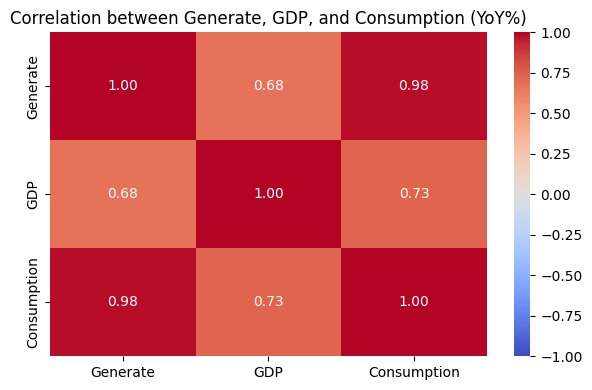

In [ ]:
# compute correlation
corr_matrix = corr_df.corr()

# plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation between Generate, GDP, and Consumption (YoY%)")
plt.tight_layout()
plt.show()


### **1.3 ‡∏õ‡∏£‡∏∞‡∏ä‡∏≤‡∏Å‡∏£‡πÉ‡∏ô‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÑ‡∏ó‡∏¢‡∏™‡πà‡∏á‡∏ú‡∏•‡∏ï‡πà‡∏≠‡∏õ‡∏£‡∏¥‡∏°‡∏≤‡∏ì‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà**

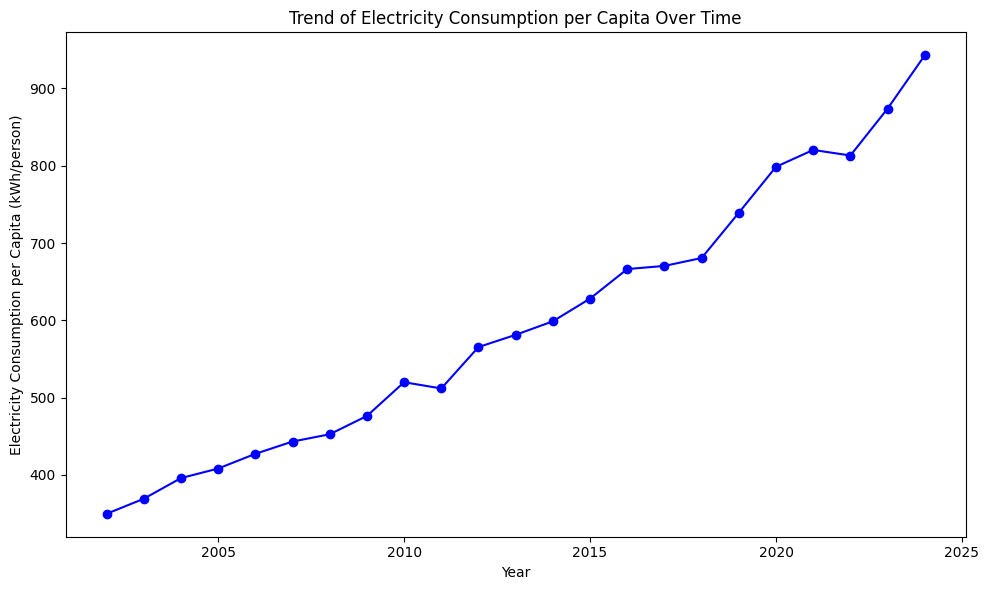

In [ ]:
Question3 = data.loc[:, ["Year-Month","Year", "Residential Total", "Total Population (People)"]]
Question3["Yearly_Resident_Comsump"]  = Question3.groupby(Question3["Year"])["Residential Total"].cumsum()
Question3 = Question3.reset_index()
Question3.set_index('Year', inplace=True)
Question3 = Question3.loc[:, ["Yearly_Resident_Comsump", "Total Population (People)"]].dropna(subset=["Total Population (People)"])
Question3.reset_index(inplace=True)

Question3["Yearly_Resident_Comsump_kWh"] = Question3["Yearly_Resident_Comsump"] * 1e6  # 1 GWh = 1e6 kWh

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏ï‡πà‡∏≠‡∏´‡∏±‡∏ß
Question3["Electricity_per_capita_kWh"] = Question3["Yearly_Resident_Comsump_kWh"] / Question3["Total Population (People)"]

# Plot ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏ï‡πà‡∏≠‡∏´‡∏±‡∏ß
plt.figure(figsize=(10,6))
plt.plot(Question3["Year"], Question3["Electricity_per_capita_kWh"], marker="o", linestyle="-", color="blue")
plt.xlabel("Year")
plt.ylabel("Electricity Consumption per Capita (kWh/person)")
plt.title("Trend of Electricity Consumption per Capita Over Time")
plt.tight_layout()
plt.show()

### **1.4 ‡∏Å‡∏≤‡∏£‡πÄ‡∏Ç‡πâ‡∏≤‡∏°‡∏≤‡∏Ç‡∏≠‡∏á‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ EV ‡∏°‡∏µ‡∏ú‡∏•‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡∏õ‡∏£‡∏¥‡∏°‡∏≤‡∏ì‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÉ‡∏ô‡∏Ñ‡∏£‡∏±‡∏ß‡πÄ‡∏£‡∏∑‡∏≠‡∏ô‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà**


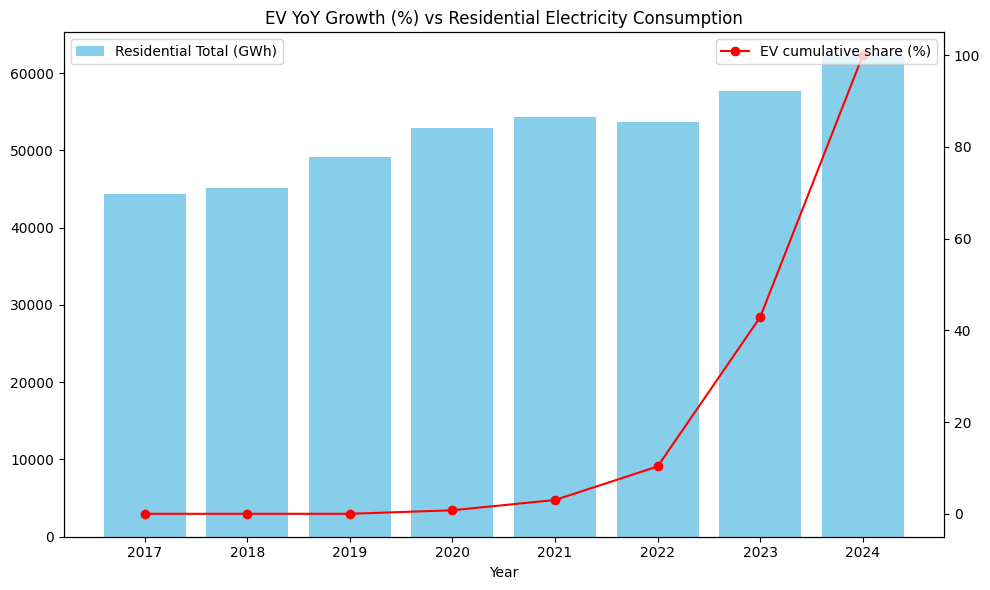

In [ ]:
# --- 1) Build yearly table ---
Question4 = data.loc[:, ["Year-Month","Year","Residential Total", "EV Car (EA)"]].sort_values(by="ID").reset_index()
Question4["EV_car_accum"] = Question4["EV Car (EA)"].cumsum()
# Question4

# --- 0) ‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏•‡∏≥‡∏î‡∏±‡∏ö‡πÄ‡∏ß‡∏•‡∏≤‡πÉ‡∏´‡πâ‡∏ñ‡∏π‡∏Å‡∏Å‡πà‡∏≠‡∏ô ---
# ‡∏ñ‡πâ‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå 'ID' ‡πÉ‡∏´‡πâ sort ‡∏î‡πâ‡∏ß‡∏¢ 'Year-Month' ‡πÅ‡∏ó‡∏ô
Question4 = data.loc[:, ["Year-Month","Year","Residential Total","EV Car (EA)"]].copy()
Question4 = Question4.sort_values("Year-Month").reset_index(drop=True)

# ‡∏¢‡∏≠‡∏î‡∏™‡∏∞‡∏™‡∏°‡∏£‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡∏≠‡∏á EV
Question4["EV_car_accum"] = Question4["EV Car (EA)"].cumsum()

# --- 1) ‡∏™‡∏£‡∏∏‡∏õ‡∏£‡∏≤‡∏¢‡∏õ‡∏µ (‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÉ‡∏ä‡πâ sum, ‡∏£‡∏ñ EV ‡∏™‡∏∞‡∏™‡∏°‡πÉ‡∏ä‡πâ‡∏Ñ‡πà‡∏≤‡∏õ‡∏•‡∏≤‡∏¢‡∏õ‡∏µ = last) ---
Question4 = (
    Question4[["Year", "Residential Total", "EV_car_accum"]]
    .groupby("Year", as_index=True)
    .agg({
        "Residential Total": "sum",
        "EV_car_accum": "last"
    })
    .sort_index()
    .tail(8)          # ‡πÄ‡∏≠‡∏≤ 8 ‡∏õ‡∏µ‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î (‡∏£‡∏ß‡∏°‡∏õ‡∏µ‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î)
    .fillna(0)
)

# ===== ‡πÄ‡∏•‡∏∑‡∏≠‡∏Å 1 ‡πÉ‡∏ô 3 ‡πÄ‡∏°‡∏ï‡∏£‡∏¥‡∏Å‡∏ï‡∏≤‡∏°‡∏Ñ‡∏ß‡∏≤‡∏°‡∏´‡∏°‡∏≤‡∏¢‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£ =====

# (A) EV YoY growth (%) ‡∏Ç‡∏≠‡∏á‡∏¢‡∏≠‡∏î‡∏™‡∏∞‡∏™‡∏° (‡πÄ‡∏´‡∏°‡∏≤‡∏∞‡∏Å‡∏±‡∏ö‡∏ä‡∏∑‡πà‡∏≠ "Growth")
Question4["EV YoY growth (%)"] = Question4["EV_car_accum"].pct_change().fillna(0) * 100

# (B) EV cumulative share (%) = ‡∏™‡∏±‡∏î‡∏™‡πà‡∏ß‡∏ô "‡∏™‡∏∞‡∏™‡∏°‡∏ï‡∏±‡πâ‡∏á‡πÅ‡∏ï‡πà‡∏ï‡πâ‡∏ô‡∏à‡∏ô‡∏ñ‡∏∂‡∏á‡∏õ‡∏µ‡∏ô‡∏±‡πâ‡∏ô" ‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏ó‡∏±‡πâ‡∏á‡∏ä‡∏∏‡∏î (0‚Üí100%)
Question4["EV cumulative share (%)"] = Question4["EV_car_accum"].cumsum() / Question4["EV_car_accum"].sum() * 100

# (C) EV portion on year (%) = ‚Äú‡∏™‡πà‡∏ß‡∏ô‡πÅ‡∏ö‡πà‡∏á‡∏ó‡∏µ‡πà‡∏õ‡∏µ‡∏ô‡∏±‡πâ‡∏ô‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÄ‡∏Ç‡πâ‡∏≤‡πÑ‡∏õ‚Äù ‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏±‡∏ö‡∏¢‡∏≠‡∏î‡∏™‡∏∞‡∏™‡∏°‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢
ev_net_add = Question4["EV_car_accum"].diff().fillna(Question4["EV_car_accum"])
Question4["EV portion on year (%)"] = (ev_net_add / Question4["EV_car_accum"].iloc[-1]) * 100

# --- 3) Plot (‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÉ‡∏ä‡πâ‡πÅ‡∏ö‡∏ö A: YoY growth %) ---
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# ‡πÅ‡∏ó‡πà‡∏á‡∏ü‡πâ‡∏≤ = ‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏†‡∏≤‡∏Ñ‡∏ö‡πâ‡∏≤‡∏ô‡πÄ‡∏£‡∏∑‡∏≠‡∏ô
ax1.bar(
    Question4.index,
    Question4["Residential Total"],
    label="Residential Total (GWh)",
    color="skyblue"
)

ax1.set_xlabel("Year")

# ‡πÄ‡∏™‡πâ‡∏ô‡πÅ‡∏î‡∏á = EV YoY growth (%)
ax2 = ax1.twinx()
ax2.plot(
    Question4.index,
    Question4["EV cumulative share (%)"],
    marker="o",
    label="EV cumulative share (%)",
    color="red"
)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("EV YoY Growth (%) vs Residential Electricity Consumption")
plt.tight_layout()
plt.show()

## **Hypothesis 2.  ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°‡∏Å‡∏≤‡∏£‡∏ú‡∏•‡∏¥‡∏ï‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏≠‡∏î‡∏Ñ‡∏•‡πâ‡∏≠‡∏á‡∏ï‡πà‡∏≠‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà**

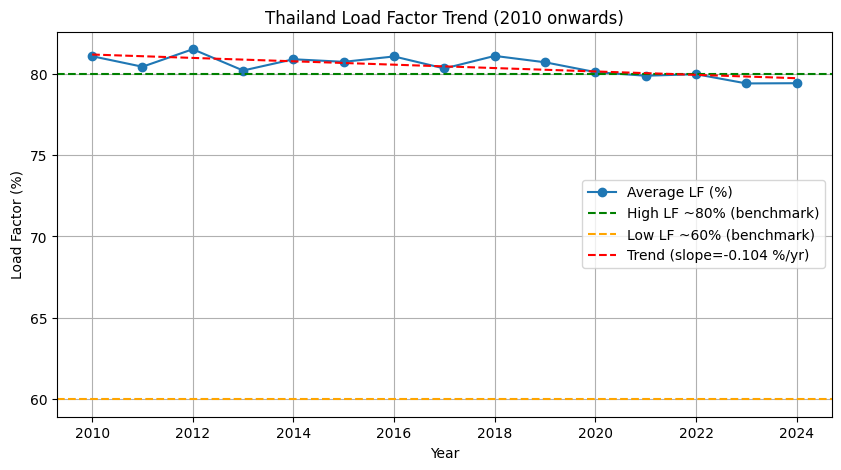

In [ ]:
# ‡∏ó‡∏≥‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏∞‡∏≠‡∏≤‡∏î‡∏Ñ‡πà‡∏≤ LF
df_lf = data.copy()
df_lf["LOAD FACTOR (%)"] = pd.to_numeric(df_lf["LOAD FACTOR (%)"], errors="coerce")

# ‡∏Å‡∏£‡∏≠‡∏á‡πÄ‡∏â‡∏û‡∏≤‡∏∞‡∏õ‡∏µ >= 2010
lf_year = df_lf[df_lf["Year"] >= 2010].groupby("Year", as_index=False).agg({
    "LOAD FACTOR (%)": "mean"
})

# Plot
plt.figure(figsize=(10,5))
plt.plot(lf_year["Year"], lf_year["LOAD FACTOR (%)"], marker='o', label="Average LF (%)")

# Benchmarks
plt.axhline(80, color='green', linestyle='--', label="High LF ~80% (benchmark)")
plt.axhline(60, color='orange', linestyle='--', label="Low LF ~60% (benchmark)")

# Trend line
x = lf_year["Year"].values.astype(float)
y = lf_year["LOAD FACTOR (%)"].values.astype(float)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label=f"Trend (slope={z[0]:.3f} %/yr)")

# # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì R¬≤ (optional)
# yhat = p(x)
# ss_res = np.sum((y - yhat)**2)
# ss_tot = np.sum((y - y.mean())**2)
# r2 = 1 - ss_res/ss_tot
# plt.title(f"Thailand Load Factor Trend (2010 onwards) (R¬≤={r2:.3f})")

plt.title("Thailand Load Factor Trend (2010 onwards)")
plt.xlabel("Year")
plt.ylabel("Load Factor (%)")
plt.grid(True)
plt.legend()
plt.show()

üîπ 1. Load Factor (LF) Trend (2010‚Äì2024)

‡∏Ñ‡πà‡∏≤ LF ‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏≠‡∏¢‡∏π‡πà‡∏£‡∏≤‡∏ß ‡πÜ 79‚Äì82% ‡∏ï‡∏•‡∏≠‡∏î‡∏ä‡πà‡∏ß‡∏á 2010‚Äì2024

Slope = ‚Äì0.104 %/yr ‚Üí ‡∏´‡∏°‡∏≤‡∏¢‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ß‡πà‡∏≤ LF ‡∏Ç‡∏≠‡∏á‡πÑ‡∏ó‡∏¢ ‡∏•‡∏î‡∏•‡∏á‡πÄ‡∏•‡πá‡∏Å‡∏ô‡πâ‡∏≠‡∏¢‡∏ó‡∏∏‡∏Å‡∏õ‡∏µ (‡∏£‡∏∞‡∏ö‡∏ö‡∏°‡∏µ‡∏Å‡∏≤‡∏£‡∏ú‡∏•‡∏¥‡∏ï‡∏™‡∏≥‡∏£‡∏≠‡∏á‡∏°‡∏≤‡∏Å‡∏Ç‡∏∂‡πâ‡∏ô‡πÄ‡∏°‡∏∑‡πà‡∏≠‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏à‡∏£‡∏¥‡∏á)

‡∏Ñ‡πà‡∏≤‡∏ó‡∏µ‡πà‡∏≠‡∏¢‡∏π‡πà‡πÄ‡∏´‡∏ô‡∏∑‡∏≠ benchmark 80% (‡πÄ‡∏™‡πâ‡∏ô‡πÄ‡∏Ç‡∏µ‡∏¢‡∏ß) ‡πÄ‡∏Å‡∏∑‡∏≠‡∏ö‡∏ó‡∏∏‡∏Å‡∏õ‡∏µ ‚Üí ‡πÅ‡∏™‡∏î‡∏á‡∏ß‡πà‡∏≤‡∏£‡∏∞‡∏ö‡∏ö‡πÑ‡∏ü‡πÑ‡∏ó‡∏¢ ‚Äú‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏™‡∏π‡∏á‚Äù ‡πÄ‡∏°‡∏∑‡πà‡∏≠‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏±‡∏ö‡∏°‡∏≤‡∏ï‡∏£‡∏ê‡∏≤‡∏ô‡∏™‡∏≤‡∏Å‡∏• (IEA/EIA ‡∏°‡∏≠‡∏á‡∏ß‡πà‡∏≤‡∏Ñ‡πà‡∏≤ 60‚Äì80% ‡πÄ‡∏õ‡πá‡∏ô‡∏õ‡∏Å‡∏ï‡∏¥)

‡πÅ‡∏ï‡πà‡∏Å‡∏≤‡∏£‡∏ó‡∏µ‡πà‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°‡∏•‡∏î‡∏•‡∏á (‡πÅ‡∏°‡πâ‡πÄ‡∏û‡∏µ‡∏¢‡∏á‡πÄ‡∏•‡πá‡∏Å‡∏ô‡πâ‡∏≠‡∏¢) ‡∏ö‡πà‡∏á‡∏ö‡∏≠‡∏Å‡∏ß‡πà‡∏≤ ‡∏Å‡∏≤‡∏£‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡πÇ‡∏£‡∏á‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÉ‡∏´‡∏°‡πà‡∏≠‡∏≤‡∏à‡πÄ‡∏£‡πá‡∏ß‡∏Å‡∏ß‡πà‡∏≤ demand growth ‚Üí ‡∏ó‡∏≥‡πÉ‡∏´‡πâ oversupply ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô


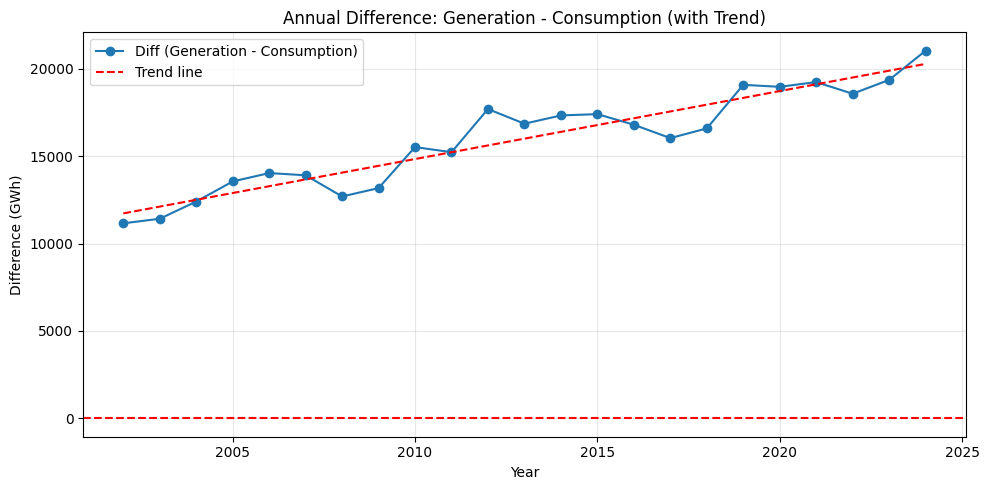

In [ ]:
df = data.copy()
# --- Ensure numeric columns ---
df["POWER GENERATION (GWh)"] = pd.to_numeric(df["POWER GENERATION (GWh)"], errors="coerce")
df["Electrical consump Grand Total (GWh)"] = pd.to_numeric(df["Electrical consump Grand Total (GWh)"], errors="coerce")

# Diff at row level (safe even if not in original data)
df["Diff (GWh)"] = df["POWER GENERATION (GWh)"] - df["Electrical consump Grand Total (GWh)"]

# --- Aggregate to annual ---
annual = (
    df.dropna(subset=["Year"])
      .groupby("Year", as_index=False)
      .agg({
          "POWER GENERATION (GWh)": "sum",
          "Electrical consump Grand Total (GWh)": "sum",
          "Diff (GWh)": "sum"
      })
      .sort_values("Year")
)

# Margin (%), guarding divide-by-zero
den = annual["Electrical consump Grand Total (GWh)"].replace(0, pd.NA)
annual["Margin (%)"] = annual["Diff (GWh)"] / den * 100

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(annual["Year"], annual["Diff (GWh)"], marker='o', label="Diff (Generation - Consumption)")
plt.axhline(0, color='red', linestyle='--')

# Trend line (label only "Trend line")
x = annual["Year"].values.astype(float)
y = annual["Diff (GWh)"].values.astype(float)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(annual["Year"], p(x), "r--", label="Trend line")

plt.title("Annual Difference: Generation - Consumption (with Trend)")
plt.xlabel("Year")
plt.ylabel("Difference (GWh)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Oversupply (Generation ‚Äì Consumption) Trend (2002‚Äì2024)

‡∏™‡πà‡∏ß‡∏ô‡∏ï‡πà‡∏≤‡∏á ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô‡∏ï‡πà‡∏≠‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á ‡∏à‡∏≤‡∏Å ~11,000 GWh (2002) ‚Üí ‡πÄ‡∏Å‡∏¥‡∏ô 20,000 GWh (2024)

‡πÄ‡∏™‡πâ‡∏ô trend (‡∏™‡∏µ‡πÅ‡∏î‡∏á) ‡∏ä‡∏µ‡πâ‡∏ä‡∏±‡∏î‡∏ß‡πà‡∏≤ oversupply ‡∏Ç‡∏≠‡∏á‡πÑ‡∏ó‡∏¢ ‡πÇ‡∏ï‡∏Ç‡∏∂‡πâ‡∏ô‡πÄ‡∏£‡∏∑‡πà‡∏≠‡∏¢ ‡πÜ

Oversupply ‡∏™‡∏π‡∏á‡∏Ç‡∏∂‡πâ‡∏ô‡∏´‡∏°‡∏≤‡∏¢‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ß‡πà‡∏≤:

‡πÑ‡∏ó‡∏¢ ‡∏°‡∏µ‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏ú‡∏•‡∏¥‡∏ï‡∏™‡∏≥‡∏£‡∏≠‡∏á (reserve margin) ‡∏™‡∏π‡∏á‡∏°‡∏≤‡∏Å ‚Üí ‡∏£‡∏∞‡∏ö‡∏ö‡∏°‡∏±‡πà‡∏ô‡∏Ñ‡∏á ‡∏õ‡∏•‡∏≠‡∏î blackout

‡πÅ‡∏ï‡πà‡∏Å‡πá‡∏™‡∏∞‡∏ó‡πâ‡∏≠‡∏ô‡∏ß‡πà‡∏≤ ‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡πÄ‡∏Å‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏à‡∏≥‡πÄ‡∏õ‡πá‡∏ô ‚Üí ‡∏ï‡πâ‡∏ô‡∏ó‡∏∏‡∏ô‡∏Ñ‡πà‡∏≤‡πÑ‡∏ü (‡∏Ñ‡πà‡∏≤ Ft) ‡∏≠‡∏≤‡∏à‡∏™‡∏π‡∏á‡∏Ç‡∏∂‡πâ‡∏ô‡πÄ‡∏û‡∏£‡∏≤‡∏∞‡∏ï‡πâ‡∏≠‡∏á‡∏à‡πà‡∏≤‡∏¢‡∏Ñ‡πà‡∏≤‡∏Ñ‡∏ß‡∏≤‡∏°‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏à‡πà‡∏≤‡∏¢ (Availability Payment) ‡πÉ‡∏´‡πâ‡πÇ‡∏£‡∏á‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏ó‡∏µ‡πà‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ‡πÄ‡∏î‡∏¥‡∏ô‡πÄ‡∏Ñ‡∏£‡∏∑‡πà‡∏≠‡∏á‡πÄ‡∏ï‡πá‡∏°‡∏ó‡∏µ‡πà

‡∏™‡∏£‡∏∏‡∏õ Insight
üîπ 3. ‡∏Å‡∏≤‡∏£‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡πÇ‡∏¢‡∏á 2 ‡∏Å‡∏£‡∏≤‡∏ü

LF ‡∏•‡∏î‡∏•‡∏á (‡πÄ‡∏•‡πá‡∏Å‡∏ô‡πâ‡∏≠‡∏¢) + Oversupply ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô ‚Üí ‡πÄ‡∏õ‡πá‡∏ô‡∏™‡∏±‡∏ç‡∏ç‡∏≤‡∏ì‡∏ä‡∏±‡∏î‡πÄ‡∏à‡∏ô‡∏ß‡πà‡∏≤ ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≥‡∏£‡∏≠‡∏á‡πÉ‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏°‡∏≤‡∏Å‡πÄ‡∏Å‡∏¥‡∏ô‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏à‡∏£‡∏¥‡∏á

‡πÉ‡∏ô‡πÄ‡∏ä‡∏¥‡∏á‡∏ß‡∏¥‡∏®‡∏ß‡∏Å‡∏£‡∏£‡∏°‡∏£‡∏∞‡∏ö‡∏ö‡πÑ‡∏ü ‚Üí ‡∏î‡∏µ‡∏ï‡πà‡∏≠‡∏Ñ‡∏ß‡∏≤‡∏°‡∏°‡∏±‡πà‡∏ô‡∏Ñ‡∏á (reliability) ‡πÅ‡∏ï‡πà ‡πÑ‡∏°‡πà‡∏Ñ‡∏∏‡πâ‡∏°‡∏Ñ‡πà‡∏≤‡πÉ‡∏ô‡πÄ‡∏®‡∏£‡∏©‡∏ê‡∏®‡∏≤‡∏™‡∏ï‡∏£‡πå‡∏û‡∏•‡∏±‡∏á‡∏á‡∏≤‡∏ô

‡∏Å‡∏≤‡∏£‡∏°‡∏µ oversupply ‡∏™‡∏π‡∏á‡∏ï‡πà‡∏≠‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á‡∏™‡∏∞‡∏ó‡πâ‡∏≠‡∏ô‡∏ô‡πÇ‡∏¢‡∏ö‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡πÇ‡∏£‡∏á‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÅ‡∏ö‡∏ö ‚Äúbuild ahead of demand‚Äù ‡∏Ç‡∏≠‡∏á‡πÑ‡∏ó‡∏¢

üìå Insight ‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢

Positive: ‡πÑ‡∏ó‡∏¢‡∏°‡∏µ‡∏£‡∏∞‡∏ö‡∏ö‡πÑ‡∏ü‡∏ó‡∏µ‡πà‡∏°‡∏±‡πà‡∏ô‡∏Ñ‡∏á‡∏°‡∏≤‡∏Å, blackout ‡∏ô‡πâ‡∏≠‡∏¢, ‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡πÄ‡∏ï‡∏¥‡∏ö‡πÇ‡∏ï demand ‡πÑ‡∏î‡πâ

Negative: Oversupply ‡∏™‡∏π‡∏á ‚Üí ‡∏Ñ‡πà‡∏≤‡πÑ‡∏ü‡πÑ‡∏°‡πà‡∏ñ‡∏π‡∏Å‡∏•‡∏á‡πÄ‡∏û‡∏£‡∏≤‡∏∞‡∏°‡∏µ fixed cost ‡∏à‡∏≤‡∏Å‡πÇ‡∏£‡∏á‡πÑ‡∏ü‡∏ü‡πâ‡∏≤, LF ‡∏•‡∏î‡∏•‡∏á‡∏ó‡∏≥‡πÉ‡∏´‡πâ‡πÉ‡∏ä‡πâ‡∏õ‡∏£‡∏∞‡πÇ‡∏¢‡∏ä‡∏ô‡πå‡πÇ‡∏£‡∏á‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÑ‡∏°‡πà‡πÄ‡∏ï‡πá‡∏°‡∏ó‡∏µ‡πà

Policy implication: ‡∏Ñ‡∏ß‡∏£‡∏ä‡∏∞‡∏•‡∏≠‡∏Å‡∏≤‡∏£‡∏•‡∏á‡∏ó‡∏∏‡∏ô‡πÇ‡∏£‡∏á‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÉ‡∏´‡∏°‡πà, ‡∏´‡∏±‡∏ô‡πÑ‡∏õ‡πÄ‡∏û‡∏¥‡πà‡∏° demand response, energy efficiency, renewable integration ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏•‡∏î oversupply


## **Hypothesis 3 ‡∏Å‡∏≤‡∏£‡∏ú‡∏•‡∏¥‡∏ï‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡πÉ‡∏ô‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÑ‡∏ó‡∏¢ ‡∏°‡∏µ‡∏™‡∏±‡∏î‡∏™‡πà‡∏ß‡∏ô‡∏Å‡∏≤‡∏£‡∏ú‡∏•‡∏¥‡∏ï‡∏à‡∏≤‡∏Å‡∏†‡∏≤‡∏Ñ‡∏£‡∏±‡∏ê‡πÅ‡∏•‡∏∞‡∏†‡∏≤‡∏Ñ‡πÄ‡∏≠‡∏Å‡∏ä‡∏ô ‡πÄ‡∏õ‡πá‡∏ô‡∏≠‡∏±‡∏ï‡∏£‡∏≤‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏õ‡πá‡∏ô‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÑ‡∏£**

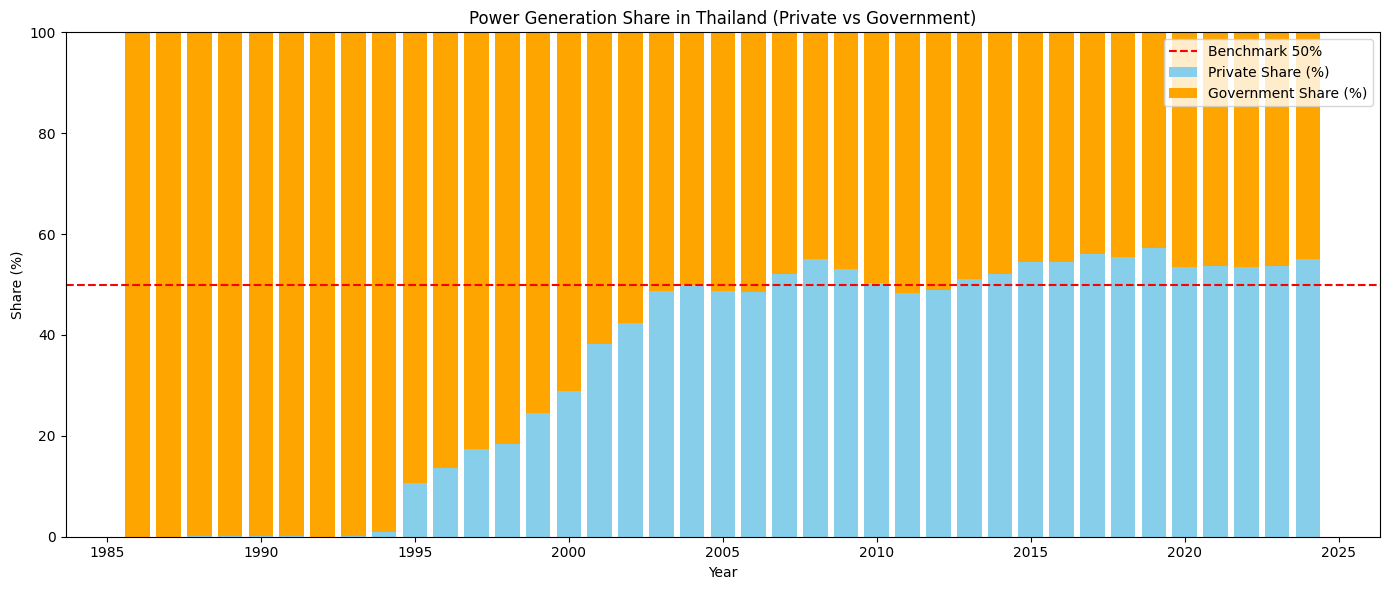

In [ ]:
Gen = pd.read_excel(url, sheet_name="Elec_Gen")
# ‡πÄ‡∏ï‡∏£‡∏µ‡∏¢‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
df = Gen[["Year", "EGAT TOTAL", "Private Power Plant "]].dropna()
df = df.groupby("Year").sum().reset_index()

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡∏™‡∏±‡∏î‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏õ‡πá‡∏ô %
df["Gov Share (%)"] = df["EGAT TOTAL"] / (df["EGAT TOTAL"] + df["Private Power Plant "]) * 100
df["Private Share (%)"] = df["Private Power Plant "] / (df["EGAT TOTAL"] + df["Private Power Plant "]) * 100

# Plot stacked bar (‡∏™‡∏•‡∏±‡∏ö‡πÉ‡∏´‡πâ Private ‡∏≠‡∏¢‡∏π‡πà‡∏•‡πà‡∏≤‡∏á, Gov ‡∏≠‡∏¢‡∏π‡πà‡∏ö‡∏ô)
plt.figure(figsize=(14,6))
plt.bar(df["Year"], df["Private Share (%)"], label="Private Share (%)", color="skyblue")
plt.bar(df["Year"], df["Gov Share (%)"], bottom=df["Private Share (%)"], label="Government Share (%)", color="orange")

# ‡πÄ‡∏™‡πâ‡∏ô benchmark 50%
plt.axhline(50, color="red", linestyle="--", linewidth=1.5, label="Benchmark 50%")

plt.title("Power Generation Share in Thailand (Private vs Government)")
plt.xlabel("Year")
plt.ylabel("Share (%)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()